In [1]:
from augmentation import fault_fold_augment, horizontal_flip_augment, enlarge_and_crop_augment, visualize_augment
from dataloader import SeismicDatasetv2, reconstruct_data, fuse_segmentations, plot_batch, plot_slice
from losses import DiceLoss, consistency_loss
from networks.vit_seg_gan_two_stage import Discriminator, TSViT_seg

import numpy as np
import matplotlib.pyplot as plt
import torch, os, logging
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
from tensorboardX import SummaryWriter
from itertools import cycle
from tqdm import tqdm
import datetime

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

torch.cuda.empty_cache() 

print(torch.cuda.memory_summary(device=None, abbreviated=False))


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

set_device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    set_device = 'cuda'
else:
    print("No GPU available!")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [6]:
batch_size = 5

pgs_data_full_il = SeismicDatasetv2('datasets/pgs_cropped_1.npy', 
                                    None, enforce_cube=True, train_size=1.0)
pgs_loader_full_il = DataLoader(pgs_data_full_il, batch_size=batch_size, shuffle=False, drop_last=False)
pgs_data_full_xl = SeismicDatasetv2('datasets/pgs_cropped_1.npy', 
                                    None, enforce_cube=True, orientation=1, train_size=1.0)
pgs_loader_full_xl = DataLoader(pgs_data_full_xl, batch_size=batch_size, shuffle=False, drop_last=False)

tnw_data_full_il = SeismicDatasetv2('datasets/TNW_small2.npy', 
                                    None, enforce_cube=True, train_size=1.0)
tnw_loader_full_il = DataLoader(tnw_data_full_il, batch_size=batch_size, shuffle=False, drop_last=False)
tnw_data_full_xl = SeismicDatasetv2('datasets/TNW_small2.npy', 
                                    None, enforce_cube=True, orientation=1, train_size=1.0)
tnw_loader_full_xl = DataLoader(tnw_data_full_xl, batch_size=batch_size, shuffle=False, drop_last=False)

Input Shape: (752, 663, 614)
Output Shape: (672, 448, 448) | n_buffer: 1 | Class List: [0]
Input Shape: (752, 663, 614)
Output Shape: (672, 448, 448) | n_buffer: 1 | Class List: [0]
Input Shape: (450, 524, 572)
Output Shape: (448, 448, 448) | n_buffer: 1 | Class List: [0]
Input Shape: (450, 524, 572)
Output Shape: (448, 448, 448) | n_buffer: 1 | Class List: [0]


Input Shape: (232, 1034, 501)
Output Shape: (224, 224, 348) | n_buffer: 1 | Class List: [0]
Input Shape: (450, 524, 572)
Output Shape: (224, 224, 398) | n_buffer: 1 | Class List: [0]
Input Shape: (752, 663, 614)
Output Shape: (224, 224, 427) | n_buffer: 1 | Class List: [0]
Input Shape: (1006, 782, 590)
Output Shape: (224, 224, 293) | n_buffer: 1 | Class List: [2 4 5 6]
Input Shape: (1006, 782, 590)
Output Shape: (896, 672, 224) | n_buffer: 1 | Class List: [1 2 3 4 5 6]
Input Shape: (1006, 782, 590)
Output Shape: (896, 224, 672) | n_buffer: 1 | Class List: [1 2 3 4 5 6]
Input Shape: (255, 701, 401)
Output Shape: (224, 224, 158) | n_buffer: 1 | Class List: [0 1 2 3 4]
Input Shape: (255, 701, 401)
Output Shape: (224, 672, 224) | n_buffer: 1 | Class List: [0 1 2 3 4 5]
Input Shape: (255, 701, 401)
Output Shape: (224, 224, 672) | n_buffer: 1 | Class List: [0 1 2 3 4 5]
Input Shape: (300, 300, 300)
Output Shape: (224, 224, 148) | n_buffer: 1 | Class List: [0 1 2 3 4 5 6 7]
Input Shape: (300,

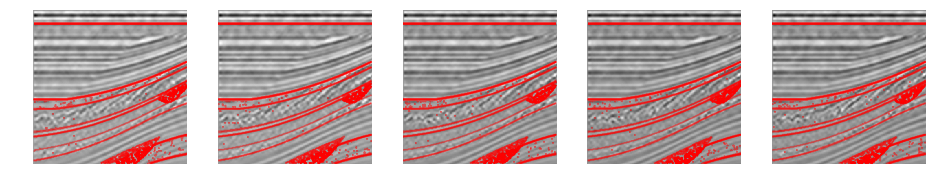

In [7]:
segy_data_1 = SeismicDatasetv2('datasets/Thebe_small2.npy', None, random_crop=True)
segy_loader_1 = DataLoader(segy_data_1, batch_size=batch_size, shuffle=False, drop_last=True)
segy_data_2 = SeismicDatasetv2('datasets/TNW_small2.npy', None, random_crop=True)
segy_loader_2 = DataLoader(segy_data_2, batch_size=batch_size, shuffle=False, drop_last=True)
segy_data_3 = SeismicDatasetv2('datasets/pgs_cropped_1.npy', None, random_crop=True)
segy_loader_3 = DataLoader(segy_data_3, batch_size=batch_size, shuffle=False, drop_last=True)

train_data_1 = SeismicDatasetv2('datasets/parihaka_seamai_train_seismic.npy', 
                                'datasets/parihaka_seamai_train_labels.npy', train_size=0.5, random_crop=True)
val_data_1_il = SeismicDatasetv2('datasets/parihaka_seamai_train_seismic.npy',
                                 'datasets/parihaka_seamai_train_labels.npy',
                                 enforce_cube=True, train_size=0.5, train=False)
val_data_1_xl = SeismicDatasetv2('datasets/parihaka_seamai_train_seismic.npy',
                                 'datasets/parihaka_seamai_train_labels.npy',
                                 enforce_cube=True, orientation=1, train_size=0.5, train=False)

train_data_2 = SeismicDatasetv2('datasets/netherlands_f3_alaudah_2019_train_seismic.npy', 
                                'datasets/netherlands_f3_alaudah_2019_train_labels.npy', train_size=0.4, random_crop=True)
val_data_2_il = SeismicDatasetv2('datasets/netherlands_f3_alaudah_2019_train_seismic.npy', 
                                 'datasets/netherlands_f3_alaudah_2019_train_labels.npy', 
                                 enforce_cube=True, train_size=0.4, train=False)
val_data_2_xl = SeismicDatasetv2('datasets/netherlands_f3_alaudah_2019_train_seismic.npy', 
                                 'datasets/netherlands_f3_alaudah_2019_train_labels.npy', 
                                 enforce_cube=True, orientation=1, train_size=0.4, train=False)

train_data_3 = SeismicDatasetv2('datasets/syndata_1_seismic.npy', 
                                'datasets/syndata_1_labels.npy', train_size=0.5, random_crop=True)
val_data_3 = SeismicDatasetv2('datasets/syndata_1_seismic.npy', 
                              'datasets/syndata_1_labels.npy', 
                              train_size=0.5, train=False)

train_data_4 = SeismicDatasetv2('datasets/penobscot_lias_cropped_seismic.npy', 
                                'datasets/penobscot_lias_cropped_labels.npy', train_size=0.5, random_crop=True)
val_data_4_il = SeismicDatasetv2('datasets/penobscot_lias_cropped_seismic.npy', 
                                 'datasets/penobscot_lias_cropped_labels.npy', 
                                 enforce_cube=True, train_size=0.5, train=False)
val_data_4_xl = SeismicDatasetv2('datasets/penobscot_lias_cropped_seismic.npy', 
                                 'datasets/penobscot_lias_cropped_labels.npy', 
                                 enforce_cube=True, orientation=1, train_size=0.5, train=False)

train_loader_1 = DataLoader(train_data_1, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_1_il = DataLoader(val_data_1_il, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader_1_xl = DataLoader(val_data_1_xl, batch_size=batch_size, shuffle=False, drop_last=False)

train_loader_2 = DataLoader(train_data_2, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_2_il = DataLoader(val_data_2_il, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader_2_xl = DataLoader(val_data_2_xl, batch_size=batch_size, shuffle=False, drop_last=False)

train_loader_3 = DataLoader(train_data_3, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_3 = DataLoader(val_data_3, batch_size=batch_size, shuffle=False, drop_last=False)

train_loader_4 = DataLoader(train_data_4, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_4_il = DataLoader(val_data_4_il, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader_4_xl = DataLoader(val_data_4_xl, batch_size=batch_size, shuffle=False, drop_last=False)

plot_batch(val_loader_3, 0)

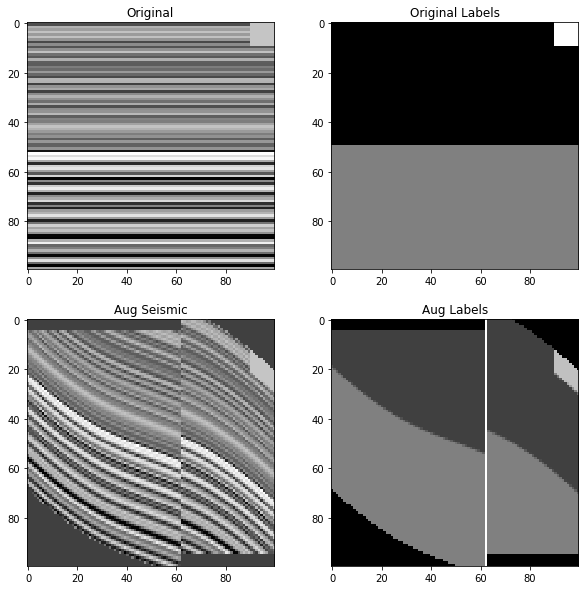

In [8]:
aug = fault_fold_augment()
visualize_augment(aug)

# Training

In [ ]:
trainloader = train_loader_3
num_classes = train_data_3.num_classes

model = TSViT_seg().to(set_device)
discriminator = Discriminator().to(set_device)

unlabeled_loaders = [segy_loader_1, train_loader_4, train_loader_2, segy_loader_2]
current_unlabeled_idx = 0
labeled_ratio = 0.5
consistency_weight = 0.5

base_lr = 0.01
snapshot_path = 'model/model_trained_4'
path_tag = 'syndata_ssl_def_loss_3_aug_2_stage_var_ganassist_3_nstack_5_bs_'

ce_loss_1 = CrossEntropyLoss(ignore_index=-1)
ce_loss_2 = CrossEntropyLoss(ignore_index=-1)
dice_loss_1 = DiceLoss(3, ignore_index=-1)
dice_loss_2 = DiceLoss(num_classes, ignore_index=-1)
optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0001)

bce_loss = nn.BCEWithLogitsLoss()
optimizer_D = optim.Adam(discriminator.parameters())

d_update_freq = 1
max_update_freq = 10

layer_1_classes = [0, 1, 2]

start_epoch = 31
try:
    model_checkpoint_filepath = os.path.join(snapshot_path, path_tag + 'epoch_' + str(start_epoch) + '.pth')
    if os.path.exists(model_checkpoint_filepath):
        checkpoint = torch.load(model_checkpoint_filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    d_update_freq = checkpoint['d_update_freq']
    print(f"Loaded checkpoint and continuing training from epoch {start_epoch}")
except:
    print("No checkpoint found. Starting training from scratch.")

writer = SummaryWriter(snapshot_path + '/log')
iter_num = 0
max_epoch = 40
max_iterations = max_epoch * len(trainloader) 

logging.info("{} iterations per epoch. {} max iterations ".format(len(trainloader), max_iterations))
best_performance = 0.0
iterator = tqdm(range(max_epoch - start_epoch), ncols=70)

for epoch_num in iterator:
    for i_batch, sampled_batch in tqdm(enumerate(trainloader)):
        aug = fault_fold_augment()
        aug2 = enlarge_and_crop_augment()
        aug3 = horizontal_flip_augment()
        
        image_batch, label_batch = sampled_batch
        image_batch = aug3.augment(aug2.augment(image_batch)).float().cuda()
        label_batch = aug3.augment(aug2.augment(label_batch)).cuda()
        
        label_batch_2 = label_batch.clone()
        label_batch[label_batch_2 >= 2] = 2
        
        unlabeled_loader = iter(unlabeled_loaders[current_unlabeled_idx])
        
        try:
            unlabeled_batch = next(unlabeled_loader)
        except StopIteration:
            current_unlabeled_idx = (current_unlabeled_idx + 1) % len(unlabeled_loaders)
            unlabeled_loader = iter(unlabeled_loaders[current_unlabeled_idx])
            unlabeled_batch = next(unlabeled_loader)

        unlabeled_batch, _ = unlabeled_batch
        unlabeled_batch_augmented = aug3.augment(aug2.augment(aug.augment(unlabeled_batch)))
        unlabeled_batch, unlabeled_batch_augmented = unlabeled_batch.float().cuda(), unlabeled_batch_augmented.float().cuda()
        
        outputs_1, _, outputs = model(image_batch)
        unlabeled_outputs_1, _, unlabeled_outputs = model(unlabeled_batch)
        unlabeled_outputs_augmented_1, _, unlabeled_outputs_augmented = model(unlabeled_batch_augmented)
        
        loss_ce_1 = ce_loss_1(outputs_1, label_batch[:].long())
        loss_dice_1 = dice_loss_1(outputs_1, label_batch, softmax=True)
        loss_unsupervised_1 = consistency_loss(
            F.softmax(unlabeled_outputs_augmented_1, dim=1),
            aug3.augment(aug2.augment(aug.augment(
                F.softmax(unlabeled_outputs_1, dim=1), 
                fault_label=True
            )))
        )
        loss_1 = labeled_ratio * (0.5 * loss_ce_1 + 0.5 * loss_dice_1) + (1 - labeled_ratio) * consistency_weight * loss_unsupervised_1
        
        loss_ce_2 = ce_loss_2(outputs, label_batch_2[:].long())
        loss_dice_2 = dice_loss_2(outputs, label_batch_2, softmax=True)
        loss_unsupervised_2 = consistency_loss(
            F.softmax(unlabeled_outputs_augmented, dim=1),
            aug3.augment(aug2.augment(aug.augment(
                F.softmax(unlabeled_outputs, dim=1), 
                fault_label=True
            )))
        )       
        loss_2 = labeled_ratio * (0.5 * loss_ce_2 + 0.5 * loss_dice_2) + (1 - labeled_ratio) * consistency_weight * loss_unsupervised_2
        
        loss = loss_1 + loss_2
        
        _, output_pred = torch.max(outputs.data, 1)
        
        d_outputs_real = discriminator(label_batch_2.unsqueeze(1).float())
        d_outputs_fake = discriminator(output_pred.detach().unsqueeze(1).float())
        
        d_loss_real = bce_loss(d_outputs_real, torch.ones_like(d_outputs_real))
        d_loss_fake = bce_loss(d_outputs_fake, torch.zeros_like(d_outputs_fake))
        d_loss = (d_loss_real + d_loss_fake) / 2
        
        if i_batch % d_update_freq == 0:
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()
        
        
        d_outputs_fake_2 = discriminator(output_pred.detach().unsqueeze(1).float())
        
        g_loss = bce_loss(d_outputs_fake_2, torch.ones_like(d_outputs_fake_2))
        final_loss = loss + g_loss        
        
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        lr_ = base_lr * (1.0 - iter_num / max_iterations) ** 0.9
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_
            
        if (g_loss.item() > 2 * d_loss.item()) and (start_epoch + epoch_num > 2):
            d_update_freq = min(d_update_freq + 1, max_update_freq)
        elif (d_loss.item() > 2 * g_loss.item()) and (start_epoch + epoch_num > 2):
            d_update_freq = max(d_update_freq - 1, 1)

        iter_num = iter_num + 1
        writer.add_scalar('info/lr', lr_, iter_num)
        writer.add_scalar('info/total_loss', loss, iter_num)
        writer.add_scalar('info/loss_ce', loss_ce_2, iter_num)

        logging.info('iteration %d : loss : %f, loss_ce: %f' % (iter_num, loss.item(), loss_ce_2.item()))

        if iter_num % 20 == 0:
            image = image_batch[1, 0:1, :, :]
            image = (image - image.min()) / (image.max() - image.min())
            writer.add_image('train/Image', image, iter_num)
            outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)
            writer.add_image('train/Prediction', outputs[1, ...] * 50, iter_num)
            labs = label_batch[1, ...].unsqueeze(0) * 50
            writer.add_image('train/GroundTruth', labs, iter_num)
    
    save_mode_path = os.path.join(snapshot_path, path_tag + 'epoch_' + str(start_epoch + epoch_num) + '.pth')
    torch.save({
        'epoch': start_epoch + epoch_num,
        'model_state_dict': model.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'd_update_freq': d_update_freq
    }, save_mode_path)
    logging.info("Saved model to {}".format(save_mode_path))
    
    print(f'loss_ce_1: {loss_ce_1.item()} | loss_ce_2: {loss_ce_2.item()}')
    print(f'loss_unsupervised_1: {loss_unsupervised_1.item()} | loss_unsupervised_2: {loss_unsupervised_2.item()}')
    print(f'g_loss: {g_loss.item()} | d_loss: {d_loss.item()}')

    if epoch_num >= max_epoch - 1:
        iterator.close()
        break

Loaded checkpoint and continuing training from epoch 32


  0%|                                           | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [01:23, 83.38s/it]
2it [02:38, 78.58s/it]
3it [03:54, 77.30s/it]
4it [05:12, 77.69s/it]
5it [06:28, 76.90s/it]
6it [07:46, 77.30s/it]
7it [09:04, 77.77s/it]
8it [10:23, 78.13s/it]
9it [11:42, 78.24s/it]
10it [12:57, 77.29s/it]
11it [14:09, 75.76s/it]
12it [15:13, 72.05s/it]
13it [16:22, 71.27s/it]
14it [17:37, 72.27s/it]
15it [18:52, 73.11s/it]
16it [20:07, 73.80s/it]
17it [21:26, 75.11s/it]
18it [22:43, 75.84s/it]
19it [24:02, 76.72s/it]
20it [25:06, 72.87s/it]
21it [26:15, 71.83s/it]
22it [27:36, 74.53s/it]
23it [28:57, 76.58s/it]
24it [30:15, 76.94s/it]
25it [31:32, 77.07s/it]
26it [32:51, 77.53s/it]
27it [34:09, 77.70s/it]
28it [35:30, 78.65s/it]
29it [36:48, 78.53s/it]
30it [38:06, 78.34s/it]
31it [39:24, 78.16s/it]
32it [40:42, 78.00s/it]
33it [42:00, 78.09s/it]
34it [43:20, 78.74s/it]
35it [44:42, 79.63s/it]
36it [46:03, 80.20s/it]
37it [47:26, 81.02s/it]
38it [48:43, 79.86s/it]
39it [5

loss_ce_1: 0.1436787098646164 | loss_ce_2: 0.5241008996963501
loss_unsupervised_1: 0.00942299421876669 | loss_unsupervised_2: 0.05635083094239235
g_loss: 2.4527158737182617 | d_loss: 0.4620321989059448



0it [00:00, ?it/s]
1it [01:18, 78.48s/it]
2it [02:38, 79.22s/it]
3it [03:52, 76.86s/it]
4it [05:12, 78.24s/it]
5it [06:36, 80.29s/it]
6it [07:54, 79.45s/it]
7it [09:15, 80.10s/it]

# Prediction

In [36]:
def load_model_and_predict(model, model_path, data_loader):
    if model is not None:
        checkpoint = torch.load(model_path)
        try:
            model.load_state_dict(checkpoint['model_state_dict'])
        except:
            model.load_state_dict(checkpoint)
    else:
        model = torch.load(model_path)
            
    model = model.to(set_device)
    model.eval()
    predictions = []
    targets = []
    features = []
    logits = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.float().cuda()
            _, _, outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            logits.extend(outputs.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())
            features.extend(images[:,images.shape[1]//2,:,:].cpu().numpy())
    return predictions, targets, features, logits

model = TSViT_seg().to(set_device)
# Valid set of Parihaka survey - xline (unseen by model)
predictions, targets, features, logits = load_model_and_predict(model, 'model/model_trained_4/syndata_ssl_def_loss_3_aug_2_stage_var_ganassist_3_nstack_5_bs_epoch_35.pth', val_loader_1_xl)

100%|██████████| 538/538 [00:46<00:00, 11.53it/s]


In [37]:
# Valid set of Parihaka survey - inline (unseen by model)
predictions_2, targets_2, features_2, logits_2 = load_model_and_predict(model, 'model/model_trained_4/syndata_ssl_def_loss_3_aug_2_stage_var_ganassist_3_nstack_5_bs_epoch_35.pth', val_loader_1_il)

100%|██████████| 538/538 [00:45<00:00, 11.71it/s]


Data Array Shape: (2688, 9, 224, 224)
Final Data Array Shape: (224, 9, 896, 672) | Original Dataset Shape: (896, 224, 672)
Data Array Shape: (2688, 9, 224, 224)
Final Data Array Shape: (224, 9, 896, 672) | Original Dataset Shape: (896, 672, 224)


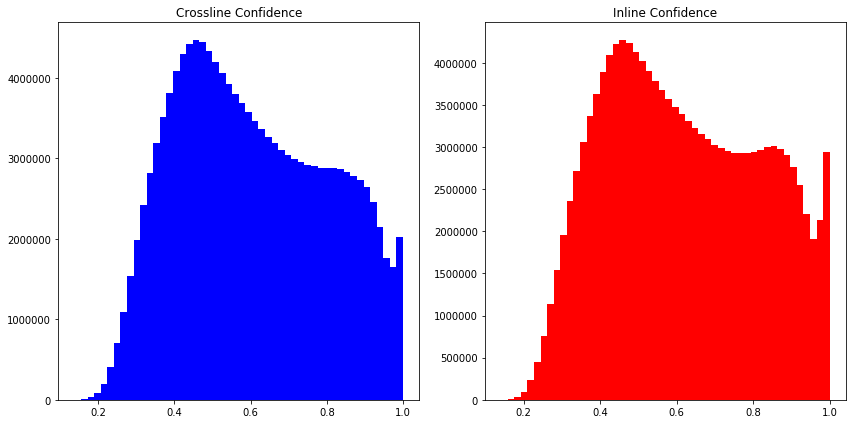

Time taken: 0:01:05.744852


In [38]:
tic = datetime.datetime.now()
logits = reconstruct_data(logits, val_data_1_xl)
logits_2 = reconstruct_data(logits_2, val_data_1_il)
fused_segmentation, combined_probs = fuse_segmentations(logits, logits_2)
toc = datetime.datetime.now()
print(f'Time taken: {toc-tic}')

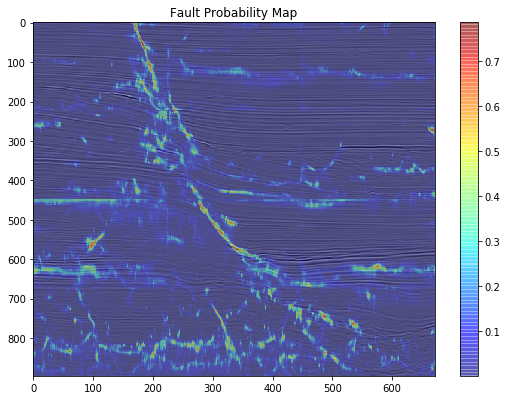

In [44]:
fault_prob_map = combined_probs[:, 1, :, :]
plt.figure(figsize=(9, 6.5))
plt.imshow(seismicarr[100, 0, :, :], cmap='gray', aspect='auto')
plt.imshow(fault_prob_map[100, :, :], cmap='jet', alpha=0.4, aspect='auto')
plt.colorbar()
plt.title("Fault Probability Map")
plt.show()

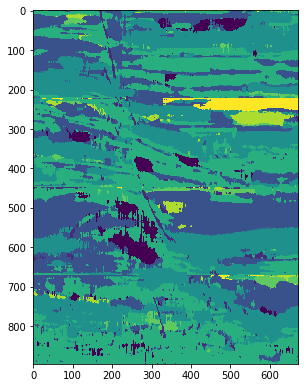

In [40]:
predarr = np.stack(fused_segmentation)
plt.figure(figsize=(8.8, 6.5))
plt.imshow(predarr[100,:,:])

Data Array Shape: (2688, 224, 224)
Final Data Array Shape: (224, 1, 896, 672) | Original Dataset Shape: (896, 672, 224)


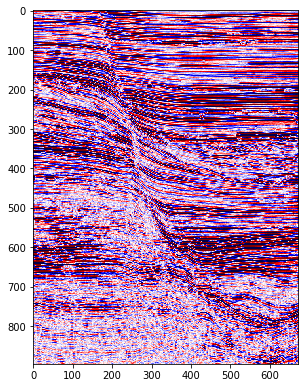

In [43]:
seismicarr = reconstruct_data(features_2, val_data_1_il)
vm = np.percentile(seismicarr, 95)
plt.figure(figsize=(8.8, 6.5))
plt.imshow(seismicarr[100,0,:,:], vmin=-vm, vmax=vm, cmap='seismic')

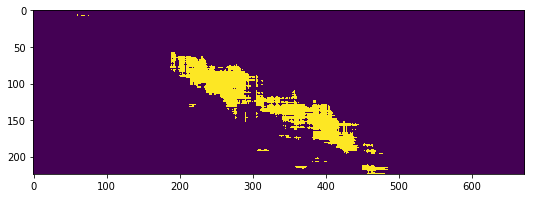

In [45]:
plt.figure(figsize=(8.8, 6.5))
plt.imshow(predarr[:,600,:] == 0)  # Channels

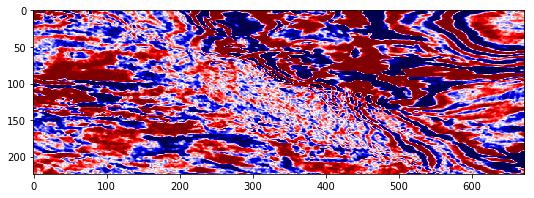

In [46]:
vm = np.percentile(seismicarr, 95)
plt.figure(figsize=(8.8, 6.5))
plt.imshow(seismicarr[:,0,600,:], vmin=-vm, vmax=vm, cmap='seismic')